In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
PATH = '/Users/tranluan/Desktop/School/Fall 2024/Data Mining/Project/predict-student-performance-from-game-play'

train_df = pd.read_csv(f'{PATH}/train.csv')
test_df = pd.read_csv(f'{PATH}/test.csv')
labels_df = pd.read_csv(f'{PATH}/train_labels.csv')
submission_df = pd.read_csv(f'{PATH}/sample_submission.csv')

In [3]:
print("Train: rows", len(train_df), "| columns", len(train_df.columns))
print("Test:  rows    ", len(test_df), "| columns", len(test_df.columns))

train_df.head(2)

Train: rows 13174211 | columns 20
Test:  rows     3728 | columns 21


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


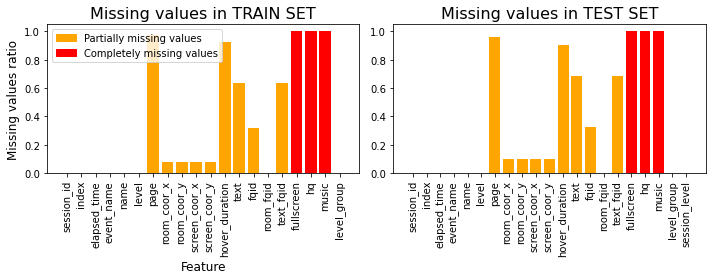

In [4]:
train_missing_ratios = train_df.isna().sum() / len(train_df)
test_missing_ratios = test_df.isna().sum() / len(test_df)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(train_missing_ratios.index,
        train_missing_ratios.values,
        color=['red' if ratio == 1 else 'orange' for ratio in train_missing_ratios.values])
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Missing values ratio', fontsize=12)
plt.title('Missing values in TRAIN SET', fontsize=16)
plt.xticks(rotation=90)
plt.legend(handles=[mpatches.Patch(color='orange'),
                    mpatches.Patch(color='red')], 
           labels=['Partially missing values', 'Completely missing values'])

plt.subplot(1, 2, 2)
plt.bar(test_missing_ratios.index,
        test_missing_ratios.values,
        color=['red' if ratio == 1 else 'orange' for ratio in test_missing_ratios.values])
plt.title('Missing values in TEST SET', fontsize=16)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

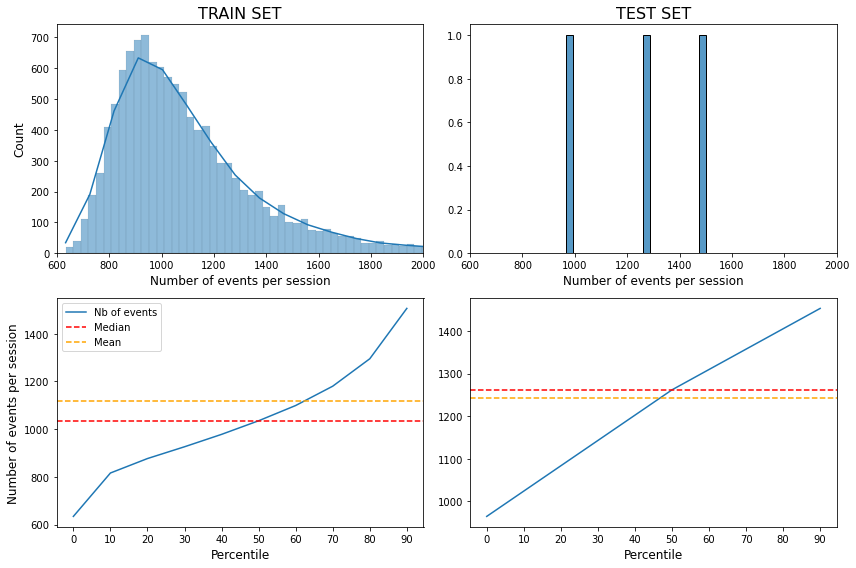

,TRAIN,TEST
Index,,
Nb of sessions,11779,3
Min nb of events,634,965
Max nb of events,19032,1501


In [5]:
train_events_per_session = train_df['session_id'].value_counts()
test_events_per_session = test_df['session_id'].value_counts()

train_percentiles, test_percentiles = [], []
xrange = range(0, 100, 10)
for q in xrange:
    train_perc = np.percentile(train_events_per_session, q)
    test_perc = np.percentile(test_events_per_session, q)
    train_percentiles.append(train_perc)
    test_percentiles.append(test_perc)
    
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.histplot(train_events_per_session.values, kde=True)
plt.xlabel("Number of events per session", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("TRAIN SET", fontsize=16)
plt.xlim(600, 2000)

plt.subplot(2, 2, 2)
sns.histplot(test_events_per_session.values, bins=20)
plt.xlabel("Number of events per session", fontsize=12), plt.ylabel("")
plt.title("TEST SET", fontsize=16)
plt.xlim(600, 2000)

plt.subplot(2, 2, 3)
plt.plot(xrange, train_percentiles)
plt.axhline(train_events_per_session.median(), color='red', ls='--')
plt.axhline(train_events_per_session.mean(), color='orange', ls='--')
plt.xlabel("Percentile", fontsize=12)
plt.ylabel("Number of events per session", fontsize=12)
plt.xticks(xrange)
plt.legend(['Nb of events', 'Median', 'Mean'])

plt.subplot(2, 2, 4)
plt.plot(xrange, test_percentiles)
plt.axhline(test_events_per_session.median(), color='red', ls='--')
plt.axhline(test_events_per_session.mean(), color='orange', ls='--')
plt.xlabel("Percentile", fontsize=12)
plt.xticks(xrange)

plt.tight_layout()
plt.show()

data = {"Index": ["Nb of sessions", "Min nb of events", "Max nb of events"],
        "TRAIN": [str(train_df['session_id'].nunique()),
                  str(train_events_per_session.min()),
                  str(train_events_per_session.max())],
        "TEST": [str(test_df['session_id'].nunique()),
                 str(test_events_per_session.min()),
                 str(test_events_per_session.max())]}
df = pd.DataFrame(data).set_index('Index')
df

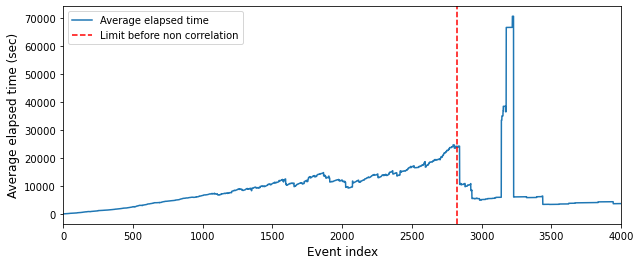

In [6]:
# Average the elapsed time in seconds for each index
avg_elapsed_time = train_df.groupby('index')['elapsed_time'].mean() / 1000

plt.figure(figsize=(10, 4))
plt.plot(avg_elapsed_time)
plt.axvline(2825, color='red', ls='--')
plt.xlabel("Event index", fontsize=12)
plt.ylabel("Average elapsed time (sec)", fontsize=12)
plt.xlim([0, 4000])
plt.legend(['Average elapsed time', 'Limit before non correlation'])

plt.show()

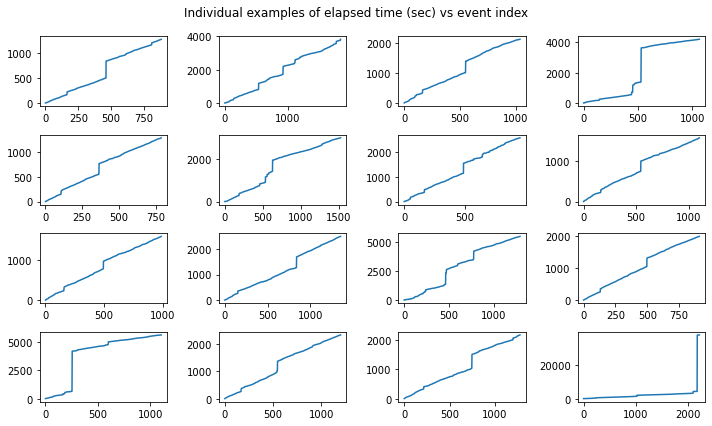

In [7]:
# Get the sessions in the dataframe
session_ids = np.array(train_df['session_id'].unique())

plt.figure(figsize=(10, 6))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    times = train_df[train_df['session_id'] == session_ids[i]]['elapsed_time']
    plt.plot(times.reset_index(drop=True) / 1000)
plt.suptitle("Individual examples of elapsed time (sec) vs event index")
plt.tight_layout()
#plt.show()   

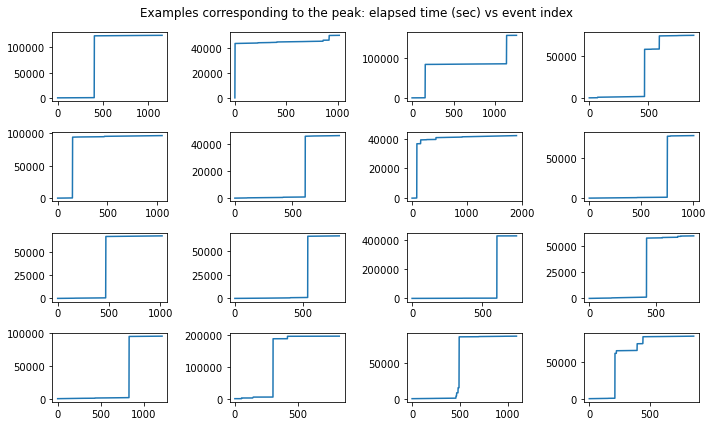

In [8]:
# Get the session ids corresponding to the peak
peak_session_ids = train_df[train_df['elapsed_time'] > 4e7]['session_id'].unique()

plt.figure(figsize=(10, 6))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    times = train_df[train_df['session_id'] == peak_session_ids[i]]['elapsed_time']
    plt.plot(times.reset_index(drop=True) / 1000)
plt.suptitle("Examples corresponding to the peak: elapsed time (sec) vs event index")
plt.tight_layout()
plt.show()

In [9]:
print("The longest session  of the TRAIN SET lasted about",
      int(train_df['elapsed_time'].max() / 8.64e7), "days.")
print("The longest session of the TEST SET lasted about",
      int(test_df['elapsed_time'].max() / 1000), "sec.")

The longest session  of the TRAIN SET lasted about 20 days.
The longest session of the TEST SET lasted about 6524 sec.


Number of event names: 11
Number of names: 6


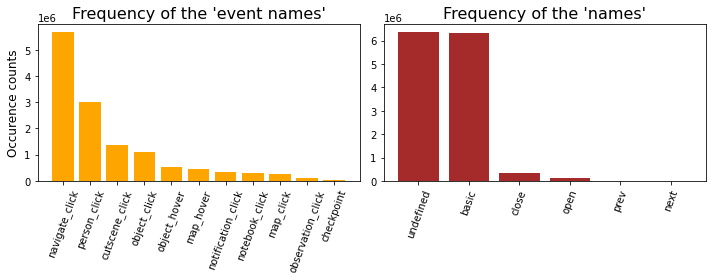

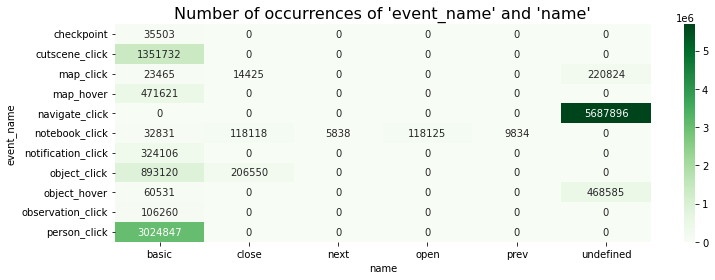

In [10]:
event_names = train_df['event_name'].value_counts()
names = train_df['name'].value_counts()

print("Number of event names:", len(event_names))
print("Number of names:", len(names))

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(event_names.index, event_names.values, color='orange')
plt.ylabel("Occurence counts", fontsize=12)
plt.title("Frequency of the 'event names'", fontsize=16)
plt.xticks(rotation=70)

plt.subplot(1, 2, 2)
plt.bar(names.index, names.values, color='brown')
plt.title("Frequency of the 'names'", fontsize=16)
plt.xticks(rotation=70)

plt.tight_layout()
plt.show()

# Pivot table
pivot_table = train_df.pivot_table(index='event_name', columns='name', aggfunc='size')
pivot_table = pivot_table.fillna(0).astype(int)
plt.figure(figsize=(12, 4))
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='Greens')
plt.title("Number of occurrences of 'event_name' and 'name'", fontsize=16)
plt.show()

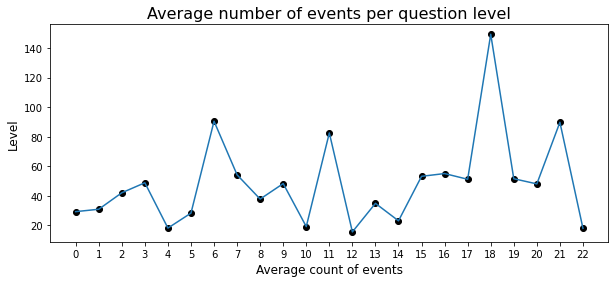

In [11]:
# Nb of events averaged per question
grouped_df = train_df.groupby(['session_id', 'level'])\
    ['index'].count().reset_index()
grouped_df.columns = ['session_id', 'level', 'index_count']
mean_counts = grouped_df.groupby('level').mean().drop('session_id', axis=1)
mean_counts

xrange = range(0, 23)
plt.figure(figsize=(10, 4))
plt.plot(mean_counts)
plt.scatter(xrange, mean_counts, color='black')
plt.title("Average number of events per question level", fontsize=16)
plt.xlabel("Average count of events", fontsize=12)
plt.ylabel("Level", fontsize=12)
plt.xticks(xrange)
plt.show()

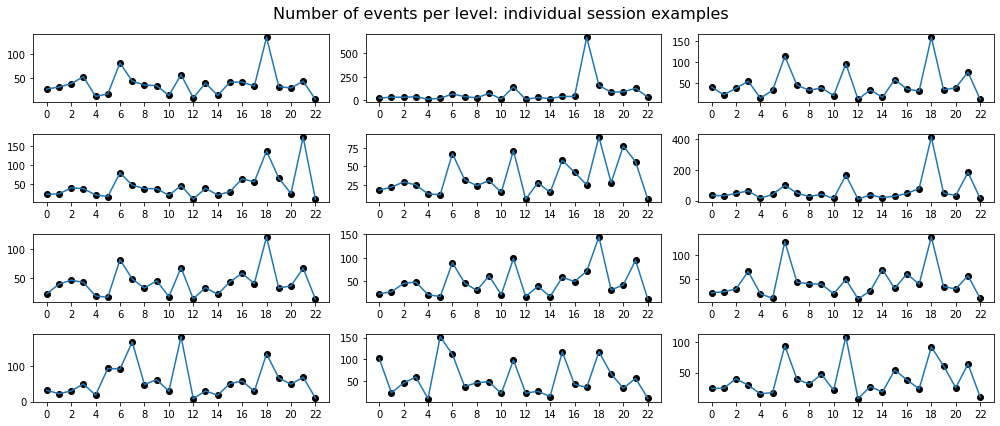

In [12]:
# Plot a few individual examples
plt.figure(figsize=(14, 6))
for i in range(12):
    plt.subplot(4, 3, i + 1)
    example = grouped_df[
        grouped_df['session_id'] == session_ids[i]]\
        ['index_count'].reset_index(drop=True)
    plt.plot(example)
    plt.scatter(range(0, 23), example, color='black')
    plt.xticks(range(0, 23, 2))
plt.suptitle("Number of events per level: individual session examples",
             fontsize=16)
plt.tight_layout()
plt.show()

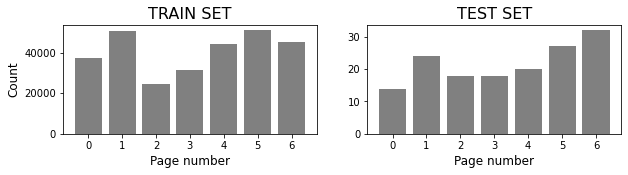

In [13]:
train_page_number_counts = train_df['page'].value_counts().sort_index()
test_page_number_counts = test_df['page'].value_counts().sort_index()
plt.figure(figsize=(10, 2))

plt.subplot(1, 2, 1)
plt.bar(range(0, 7), train_page_number_counts, color='gray')
plt.xlabel("Page number", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("TRAIN SET",
          fontsize=16)

plt.subplot(1, 2, 2)
plt.bar(range(0, 7), test_page_number_counts, color='gray')
plt.xlabel("Page number", fontsize=12)
plt.title("TEST SET",
          fontsize=16)

plt.show()

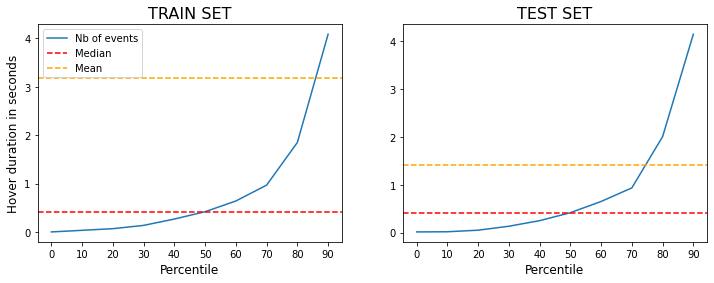

In [14]:
train_hover_durations = train_df['hover_duration'].dropna() / 1000
test_hover_durations = test_df['hover_duration'].dropna() / 1000

xrange = range(0, 100, 10)
train_percentiles , test_percentiles = [], []
for q in xrange:
    train_perc = np.percentile(train_hover_durations, q)
    test_perc = np.percentile(test_hover_durations, q)
    train_percentiles.append(train_perc)
    test_percentiles.append(test_perc)
    
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(xrange, train_percentiles)
plt.axhline(train_hover_durations.median(), color='red', ls='--')
plt.axhline(train_hover_durations.mean(), color='orange', ls='--')
plt.xticks(xrange)
plt.yticks(range(0, 5))
plt.legend(['Nb of events', 'Median', 'Mean'])
plt.xlabel("Percentile", fontsize=12)
plt.ylabel("Hover duration in seconds", fontsize=12)
plt.title("TRAIN SET", fontsize=16)

plt.subplot(1, 2, 2)
plt.plot(xrange, test_percentiles)
plt.axhline(test_hover_durations.median(), color='red', ls='--')
plt.axhline(test_hover_durations.mean(), color='orange', ls='--')
plt.xticks(xrange)
plt.xlabel("Percentile", fontsize=12)
plt.title("TEST SET", fontsize=16)

plt.show()

In [15]:
train_texts = train_df['text'].dropna().value_counts()
test_texts = test_df['text'].dropna().value_counts()
print("TRAIN | nb of unique texts:", len(train_texts))
print('-' * 60)
print(train_texts, '\n')
print("TEST | nb of unique texts:", len(test_texts))
print('-' * 60)
print(test_texts, '\n')

TRAIN | nb of unique texts: 594
------------------------------------------------------------
undefined                                           178294
\u00f0\u0178\u02dc\u0090                             24383
Hey!                                                 23724
I should go to the Capitol and tell Mrs. M!          20074
This is perfect for the exhibit.                     19987
                                                     ...  
Sorry for the delay, Boss.                               1
And where's your grampa?                                 1
Who is Teddy?                                            1
AND I know who took Teddy!                               1
Meet me back in my office and we'll get started!         1
Name: text, Length: 594, dtype: int64 

TEST | nb of unique texts: 495
------------------------------------------------------------
undefined                                     27
You can talk to a textile expert there.        7
Hey!                        

In [16]:
# Count values
train_fqids = train_df['fqid'].value_counts()
train_room_fqids = train_df['room_fqid'].value_counts()
train_text_fqids = train_df['text_fqid'].value_counts()
test_fqids = test_df['fqid'].value_counts()
test_room_fqids = test_df['room_fqid'].value_counts()
test_text_fqids = test_df['text_fqid'].value_counts()
train_fqid_bundle = [train_fqids, train_room_fqids, train_text_fqids]
test_fqid_bundle = [test_fqids, test_room_fqids, test_text_fqids]
fqid_labels = ["fqid", "room_fqid", "text_fqid"]

# Display the unique values
def print_fqids(set_name, bundle):
    for label, value in zip(fqid_labels, bundle):
        print('-' * 60)
        print(set_name, label)
        print('-' * 60)
        print(value)  
print_fqids('TRAIN', train_fqid_bundle)
print_fqids('TEST', test_fqid_bundle)

# Number of unique values recap table
data = {"Nb unique values": fqid_labels,
        "TRAIN": [len(x) for x in train_fqid_bundle],
        "TEST": [len(x) for x in test_fqid_bundle]}
df = pd.DataFrame(data).set_index('Nb unique values')
df

------------------------------------------------------------
TRAIN fqid
------------------------------------------------------------
worker           939555
archivist        563259
gramps           561000
wells            394234
toentry          392221
                  ...  
block_badge         854
need_glasses        675
block_badge_2       508
fox                 166
block_1              25
Name: fqid, Length: 127, dtype: int64
------------------------------------------------------------
TRAIN room_fqid
------------------------------------------------------------
tunic.historicalsociety.entry              1816202
tunic.wildlife.center                      1510888
tunic.historicalsociety.cage               1178391
tunic.library.frontdesk                    1075322
tunic.historicalsociety.frontdesk           972235
tunic.historicalsociety.stacks              900673
tunic.historicalsociety.closet_dirty        788096
tunic.humanecology.frontdesk                662645
tunic.historicalsoc

,TRAIN,TEST
Nb unique values,,
fqid,127,112
room_fqid,19,19
text_fqid,126,91


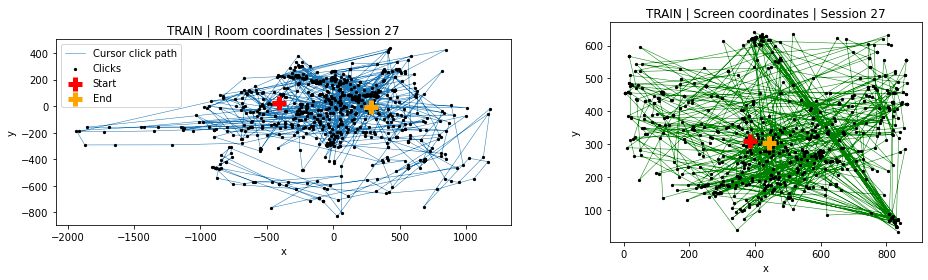

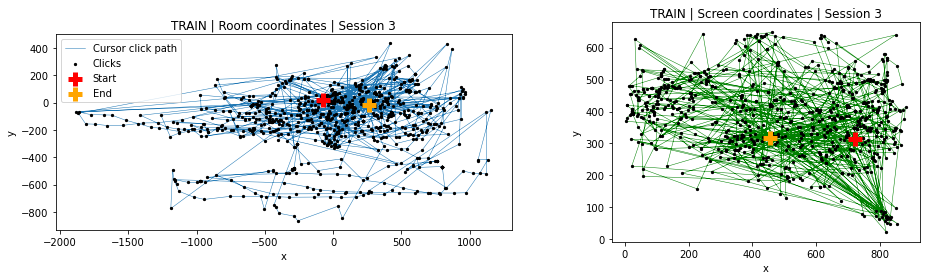

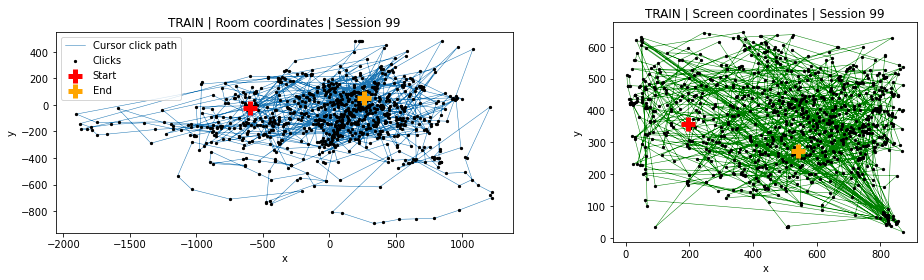

In [17]:
def plot_coordinates(i, set_name):
    df = train_df if set_name == 'TRAIN' else test_df
    session_ids = np.array(df['session_id'].unique())
    one_session = df[df['session_id'] == session_ids[i]]
    plt.figure(figsize=(14, 4))
    
    # Room coordinates
    coords = one_session[['room_coor_x', 'room_coor_y']].dropna().reset_index(drop=True)
    x = coords['room_coor_x']
    y = coords['room_coor_y']
    plt.subplot(1, 2, 1)
    plt.plot(x, y, zorder=0, lw=0.5)
    plt.scatter(x, y, s=5, color='black')
    plt.scatter(x[0], y[0], s=200, lw=5, color='red', marker='+')
    plt.scatter(x[-1:], y[-1:], s=200, lw=5, color='orange', marker='+')
    plt.legend(['Cursor click path', 'Clicks', 'Start', 'End'])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"{set_name} | Room coordinates | Session {i}")
    
    # Screen coordinates
    coords = one_session[['screen_coor_x', 'screen_coor_y']]\
        .dropna().reset_index(drop=True)
    x = coords['screen_coor_x']
    y = coords['screen_coor_y']
    plt.subplot(1, 2, 2)
    plt.plot(x, y, zorder=0, lw=0.5, color='green')
    plt.scatter(x, y, s=5, color='black')
    plt.scatter(x[0], y[0], s=200, lw=5, color='red', marker='+')
    plt.scatter(x[-1:], y[-1:], s=200, lw=5, color='orange', marker='+')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"{set_name} | Screen coordinates | Session {i}")
    
    plt.tight_layout()
    plt.show()

# Plot 3 session examples from the train set
for i in [27, 3, 99]:
    plot_coordinates(i, 'TRAIN')

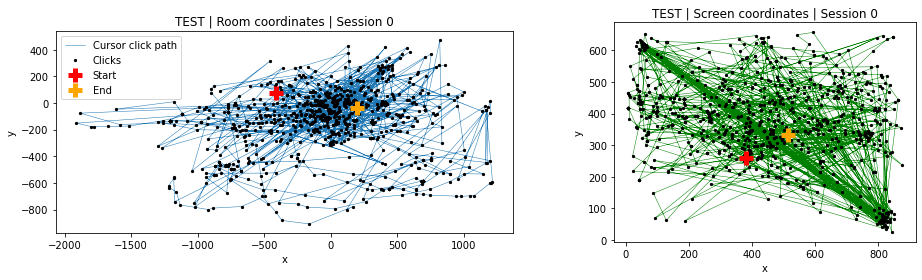

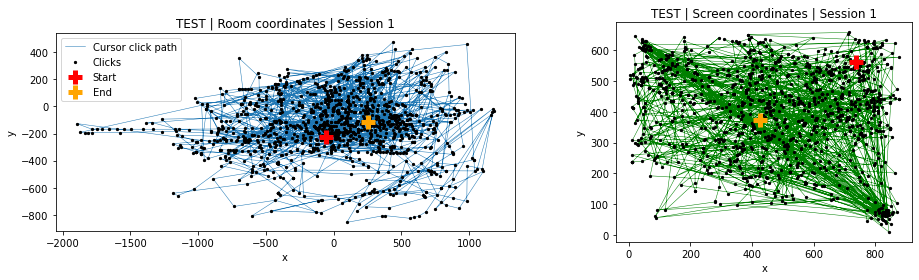

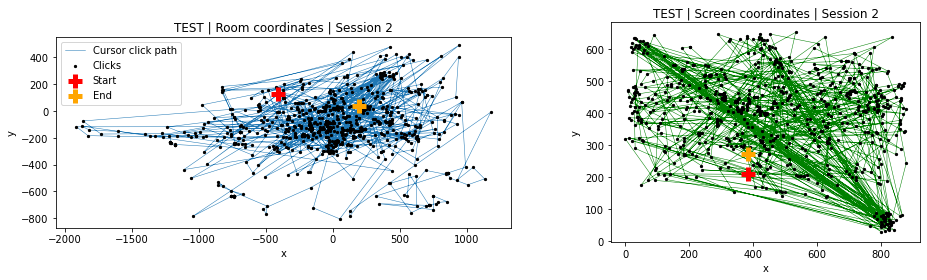

In [18]:
# Plot coordinates of all the sessions of the test set (only 3 sessions)
for i in range(3):
    plot_coordinates(i, 'TEST')

In [19]:
classes_count = labels_df['correct'].value_counts()
print("Classes count:\n", classes_count, "\n")
print("Ratio:\n", classes_count / len(labels_df))
labels_df

Classes count:
 1    149252
0     62770
Name: correct, dtype: int64 

Ratio:
 1    0.703946
0    0.296054
Name: correct, dtype: float64


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1
3,20090314363702160_q1,1
4,20090314441803444_q1,1
...,...,...
212017,22100215342220508_q18,1
212018,22100215460321130_q18,1
212019,22100217104993650_q18,1
212020,22100219442786200_q18,1


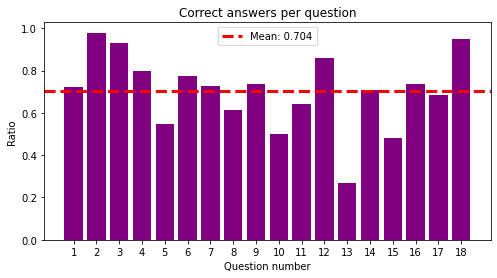

In [20]:
labels_df['question'] = labels_df['session_id'].apply(lambda x: int(x.split('_')[1][1:]))

# Calculate correct ratios
correct_ratios = []
for q in range(1, 19):
    tmp = labels_df[labels_df['question'] == q]['correct']
    ratio = tmp.sum() / len(tmp) 
    correct_ratios.append(ratio)

xrange = range(1, 19)
mean = np.mean(correct_ratios)
plt.figure(figsize=(8, 4))
plt.bar(x=xrange, height=correct_ratios, color='purple')
plt.axhline(mean, color='red', ls='--', lw=3)
plt.xticks(xrange)
plt.legend([f'Mean: {mean:.3f}'])
plt.title("Correct answers per question")
plt.xlabel("Question number")
plt.ylabel("Ratio")
plt.show()